In [27]:
from dask.distributed import Client

client = Client("tcp://10.32.2.122:42081")
client

Client Scheduler: tcp://10.32.2.122:42081 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 25 Cores: 50 Memory: 287.50 GB


# For SOSE

In [24]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
%matplotlib inline

# Validating Heat Budget (w zarr ds)

In [6]:
ds_tmp = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/budget_th.zarr'))
ds_tmp

<xarray.Dataset>
Dimensions:                  (XC: 2160, YC: 320, Z: 42, time: 438)
Coordinates:
  * XC                       (XC) float32 0.083333336 0.25 ... 359.75 359.9167
  * YC                       (YC) float32 -77.87497 -77.7083 ... -24.7083
  * Z                        (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * time                     (time) datetime64[ns] 2005-01-06 ... 2010-12-31
Data variables:
    conv_horiz_adv_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    conv_horiz_diff_flux_TH  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    conv_vert_adv_flux_TH    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    conv_vert_diff_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    lin_fs_correction_TH     (time, YC, XC) float32 dask.array<chunksize=(1, 320, 2160), meta=np.ndarray>
    surface_flux_conv_TH     (time, YC, XC) float32 dask.array<chunksize=(1, 320, 2160), meta=np.ndarray>
    sw_flux_conv_TH          (time, YC, XC, Z) float32 dask.array<chunksize=(1, 320, 2160, 42), meta=np.ndarray>
    total_tendency_TH_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>

### Entire WG column budget

In [25]:
lower_lat = 0
upper_lat = 78
left_lon = 1788
right_lon = 2159

In [26]:
#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))

In [9]:
ds_tmp_wg = ds_tmp.isel(**lat_range, **lon_range)
ds_tmp_wg

<xarray.Dataset>
Dimensions:                  (XC: 371, YC: 78, Z: 42, time: 438)
Coordinates:
  * XC                       (XC) float32 298.08334 298.25 ... 359.58334 359.75
  * YC                       (YC) float32 -77.87497 -77.7083 ... -65.04163
  * Z                        (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * time                     (time) datetime64[ns] 2005-01-06 ... 2010-12-31
Data variables:
    conv_horiz_adv_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>
    conv_horiz_diff_flux_TH  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>
    conv_vert_adv_flux_TH    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>
    conv_vert_diff_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>
    lin_fs_correction_TH     (time, YC, XC) float32 dask.array<chunksize=(1, 78, 371), meta=np.ndarray>
    surface_flux_conv_TH     (time, YC, XC) float32 dask.array<chunksize=(1, 78, 371), meta=np.ndarray>
    sw_flux_conv_TH          (time, YC, XC, Z) float32 dask.array<chunksize=(1, 78, 371, 42), meta=np.ndarray>
    total_tendency_TH_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>

In [11]:
rhs_heat = ((ds_tmp_wg.conv_horiz_adv_flux_TH + 
         ds_tmp_wg.conv_horiz_diff_flux_TH +
         ds_tmp_wg.sw_flux_conv_TH).sum(dim=['XC', 'YC', 'Z']) +
        (ds_tmp_wg.lin_fs_correction_TH + 
         ds_tmp_wg.surface_flux_conv_TH).sum(dim=['XC', 'YC'])).load()

lhs_heat = ds_tmp_wg.total_tendency_TH_truth.sum(dim=['XC', 'YC', 'Z']).load()

/srv/conda/envs/notebook/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


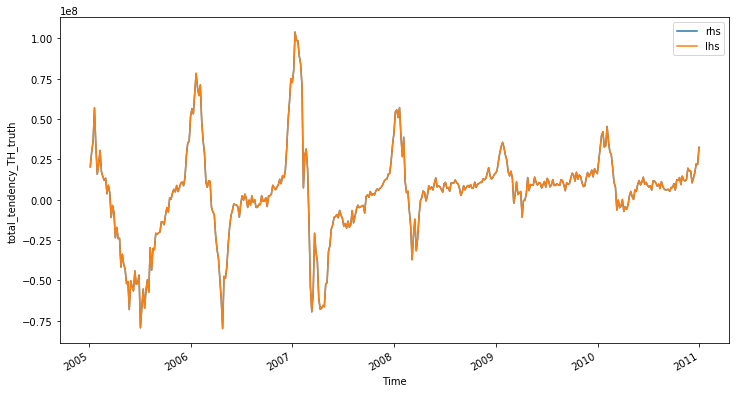

In [12]:
plt.figure(figsize=(12,6))
rhs_heat.plot(label='rhs')
lhs_heat.plot(label='lhs')
plt.legend();

### Interior WG column budget

In [35]:
#index locations corresponding to above lat/lon coordinates
lower_lat_lower = 0
upper_lat_lower = 71
left_lon_lower = 1794
right_lon_lower = 2159

lower_cell_range = dict(Zl=[27, 42])
lower_cell_range_z = dict(Z=slice(27, 42))

In [36]:
#set the boundaries
lat_range_lower = dict(YC=slice(lower_lat_lower, upper_lat_lower))
lon_range_lower = dict(XC=slice(left_lon_lower, right_lon_lower))

In [16]:
ds_tmp_wg_lower = ds_tmp.isel(**lat_range_lower, **lon_range_lower, **lower_cell_range_z)
ds_tmp_wg_lower

<xarray.Dataset>
Dimensions:                  (XC: 365, YC: 71, Z: 15, time: 438)
Coordinates:
  * XC                       (XC) float32 299.08334 299.25 ... 359.58334 359.75
  * YC                       (YC) float32 -77.87497 -77.7083 ... -66.2083
  * Z                        (Z) float32 -2046.0 -2319.0 ... -5325.0 -5575.0
  * time                     (time) datetime64[ns] 2005-01-06 ... 2010-12-31
Data variables:
    conv_horiz_adv_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 15, 71, 365), meta=np.ndarray>
    conv_horiz_diff_flux_TH  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 15, 71, 365), meta=np.ndarray>
    conv_vert_adv_flux_TH    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 15, 71, 365), meta=np.ndarray>
    conv_vert_diff_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 15, 71, 365), meta=np.ndarray>
    lin_fs_correction_TH     (time, YC, XC) float32 dask.array<chunksize=(1, 71, 365), meta=np.ndarray>
    surface_flux_conv_TH     (time, YC, XC) float32 dask.array<chunksize=(1, 71, 365), meta=np.ndarray>
    sw_flux_conv_TH          (time, YC, XC, Z) float32 dask.array<chunksize=(1, 71, 365, 15), meta=np.ndarray>
    total_tendency_TH_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 15, 71, 365), meta=np.ndarray>

In [17]:
rhs_heat_lower = ((ds_tmp_wg_lower.conv_horiz_adv_flux_TH + 
                  ds_tmp_wg_lower.conv_horiz_diff_flux_TH + 
                  ds_tmp_wg_lower.conv_vert_adv_flux_TH +
                  ds_tmp_wg_lower.conv_vert_diff_flux_TH).sum(dim=['XC', 'YC', 'Z'])).load()
                  
lhs_heat_lower = ds_tmp_wg_lower.total_tendency_TH_truth.sum(dim=['XC', 'YC', 'Z']).load()

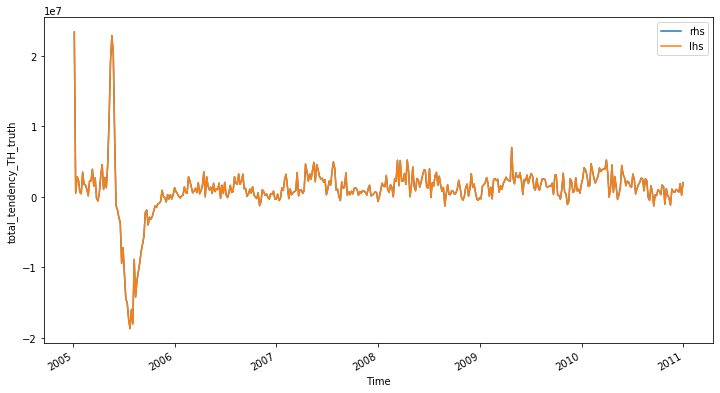

In [18]:
plt.figure(figsize=(12,6))
rhs_heat_lower.plot(label='rhs')
lhs_heat_lower.plot(label='lhs')
plt.legend();

# Validating Salt Budget (w zarr ds)

In [28]:
ds_slt = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/budget_slt.zarr'))
ds_slt

<xarray.Dataset>
Dimensions:                   (XC: 2160, YC: 320, Z: 42, time: 438)
Coordinates:
  * XC                        (XC) float32 0.083333336 0.25 ... 359.75 359.9167
  * YC                        (YC) float32 -77.87497 -77.7083 ... -24.7083
  * Z                         (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * time                      (time) datetime64[ns] 2005-01-06 ... 2010-12-31
Data variables:
    conv_horiz_adv_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    lin_fs_correction_SLT     (time, YC, XC) float32 dask.array<chunksize=(1, 320, 2160), meta=np.ndarray>
    surface_flux_conv_SLT     (time, YC, XC) float32 dask.array<chunksize=(1, 320, 2160), meta=np.ndarray>
    total_tendency_SLT_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>

### Entire WG column budget

In [29]:
ds_slt_wg = ds_slt.isel(**lat_range, **lon_range)
ds_slt_wg

<xarray.Dataset>
Dimensions:                   (XC: 371, YC: 78, Z: 42, time: 438)
Coordinates:
  * XC                        (XC) float32 298.08334 298.25 ... 359.58334 359.75
  * YC                        (YC) float32 -77.87497 -77.7083 ... -65.04163
  * Z                         (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * time                      (time) datetime64[ns] 2005-01-06 ... 2010-12-31
Data variables:
    conv_horiz_adv_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>
    lin_fs_correction_SLT     (time, YC, XC) float32 dask.array<chunksize=(1, 78, 371), meta=np.ndarray>
    surface_flux_conv_SLT     (time, YC, XC) float32 dask.array<chunksize=(1, 78, 371), meta=np.ndarray>
    total_tendency_SLT_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>

**Errors & Corrections:**
- corrected boundaries so that comparison with old salt budget could be accurate
- realized I shouldn't be including vertical terms for entire water column
- compared each term's plot with old salt budget (they all matched)
- what finally worked was the fact that I can't sum over 'Z' dimension for the surface terms... why is that? - because when I did that the plot didn't math lhs.

In [31]:
rhs_slt = ((ds_slt_wg.conv_horiz_adv_flux_SLT + 
           ds_slt_wg.conv_horiz_diff_flux_SLT).sum(dim=['XC', 'YC', 'Z']) +
           (ds_slt_wg.lin_fs_correction_SLT + 
           ds_slt_wg.surface_flux_conv_SLT).sum(dim=['XC', 'YC'])).load()

lhs_slt = ds_slt_wg.total_tendency_SLT_truth.sum(dim=['XC', 'YC', 'Z']).load()

In [33]:
lhs_slt = ds_slt_wg.total_tendency_SLT_truth.sum(dim=['XC', 'YC', 'Z']).load()

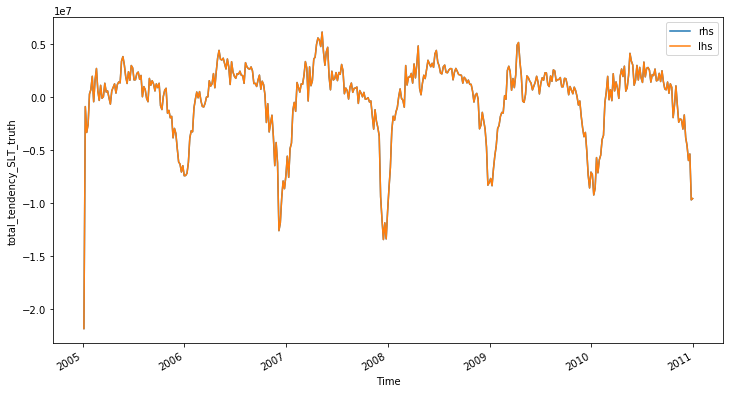

In [34]:
plt.figure(figsize=(12,6))
rhs_slt.plot(label='rhs')
lhs_slt.plot(label='lhs')
plt.legend();

### Interior WG column budget

In [37]:
ds_slt_wg_lower = ds_slt.isel(**lat_range_lower, **lon_range_lower, **lower_cell_range_z)
ds_slt_wg_lower

<xarray.Dataset>
Dimensions:                   (XC: 365, YC: 71, Z: 15, time: 438)
Coordinates:
  * XC                        (XC) float32 299.08334 299.25 ... 359.58334 359.75
  * YC                        (YC) float32 -77.87497 -77.7083 ... -66.2083
  * Z                         (Z) float32 -2046.0 -2319.0 ... -5325.0 -5575.0
  * time                      (time) datetime64[ns] 2005-01-06 ... 2010-12-31
Data variables:
    conv_horiz_adv_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 15, 71, 365), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 15, 71, 365), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 15, 71, 365), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 15, 71, 365), meta=np.ndarray>
    lin_fs_correction_SLT     (time, YC, XC) float32 dask.array<chunksize=(1, 71, 365), meta=np.ndarray>
    surface_flux_conv_SLT     (time, YC, XC) float32 dask.array<chunksize=(1, 71, 365), meta=np.ndarray>
    total_tendency_SLT_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 15, 71, 365), meta=np.ndarray>

In [39]:
rhs_slt_lower = (ds_slt_wg_lower.conv_horiz_adv_flux_SLT + 
                 ds_slt_wg_lower.conv_horiz_diff_flux_SLT + 
                 ds_slt_wg_lower.conv_vert_adv_flux_SLT +
                 ds_slt_wg_lower.conv_vert_diff_flux_SLT).sum(dim=['XC', 'YC', 'Z']).load()

lhs_slt_lower = ds_slt_wg_lower.total_tendency_SLT_truth.sum(dim=['XC', 'YC', 'Z']).load()

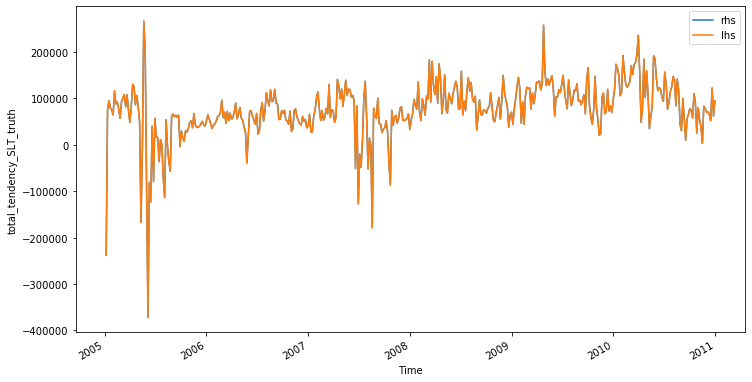

In [40]:
plt.figure(figsize=(12,6))
rhs_slt_lower.plot(label='rhs')
lhs_slt_lower.plot(label='lhs')
plt.legend();